In [2]:
import numpy as np
import matplotlib.pyplot as plt

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz' if (z != Z_MODELING[3] or True) \
    else f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
ZMIN, ZMAX = 0.1, 2. # for plots

In [3]:
data = np.load(FILENAME(Z_MODELING[0]), allow_pickle=True)

all_realizs = data['means_and_densities']
print(len(all_realizs))

sfr_behroozi_density = []
mass_HI_density = []
mean_CII_intensity = []
mean_CO_intensity = []

for realiz in all_realizs:
    sfr_behroozi_density.append(realiz['props']['sfr_behroozi']['density'])
    mass_HI_density.append(realiz['props']['MHI']['density'])
    mean_CII_intensity.append(realiz['lines']['LCII']['meanInu_Jy/sr'])
    mean_CO_intensity.append(realiz['lines']['L43']['meanInu_Jy/sr'])
    
# print means and std

print("SFR Density (Behroozi+2013)")
print("Mean:", f"{np.mean(sfr_behroozi_density):.2e}")
print("Std:", f"{np.std(sfr_behroozi_density):.2e}")
print()

print("HI mass (Padmanabhan+2017)")
print("Mean:", f"{np.mean(mass_HI_density):.2e}")
print("Std:", f"{np.std(mass_HI_density):.2e}")
print()

print("CII intensity (Delooze+2014)")
print("Mean:", f"{np.mean(mean_CII_intensity):.2e}")
print("Std:", f"{np.std(mean_CII_intensity):.2e}")
print()

50
SFR Density (Behroozi+2013)
Mean: 4.62e-02
Std: 1.02e-02

HI mass (Padmanabhan+2017)
Mean: 5.66e+07
Std: 1.07e+07

CII intensity (Delooze+2014)
Mean: 3.28e+03
Std: 1.69e+03



In [4]:
sfr_behroozi_density, mass_HI_density, mean_CII_intensity, mean_CO_intensity = [], [], [], []

for z in Z_MODELING:
    data = np.load(FILENAME(z), allow_pickle=True)
    all_realizs = data['means_and_densities']
    print(len(all_realizs))
    
    sfr, mass_HI, mean_CII, mean_CO = [], [], [], []
    
    for realiz in all_realizs:
        sfr.append(realiz['props']['sfr_behroozi']['density'])
        mass_HI.append(realiz['props']['MHI']['density'])
        mean_CII.append(realiz['lines']['LCII']['meanInu_Jy/sr'])
        if "L43" in realiz['lines']:
            mean_CO.append(realiz['lines']['L43']['meanInu_Jy/sr'])
        else:
            mean_CO.append(realiz['lines']['L54']['meanInu_Jy/sr'])
    sfr_behroozi_density.append(np.array(sfr))
    mass_HI_density.append(np.array(mass_HI))
    mean_CII_intensity.append(np.array(mean_CII))
    mean_CO_intensity.append(np.array(mean_CO))

# sfr_behroozi_density, mass_HI_density, mean_CII_intensity = np.array(sfr_behroozi_density).T, np.array(mass_HI_density).T, np.array(mean_CII_intensity).T

50
50
50
50


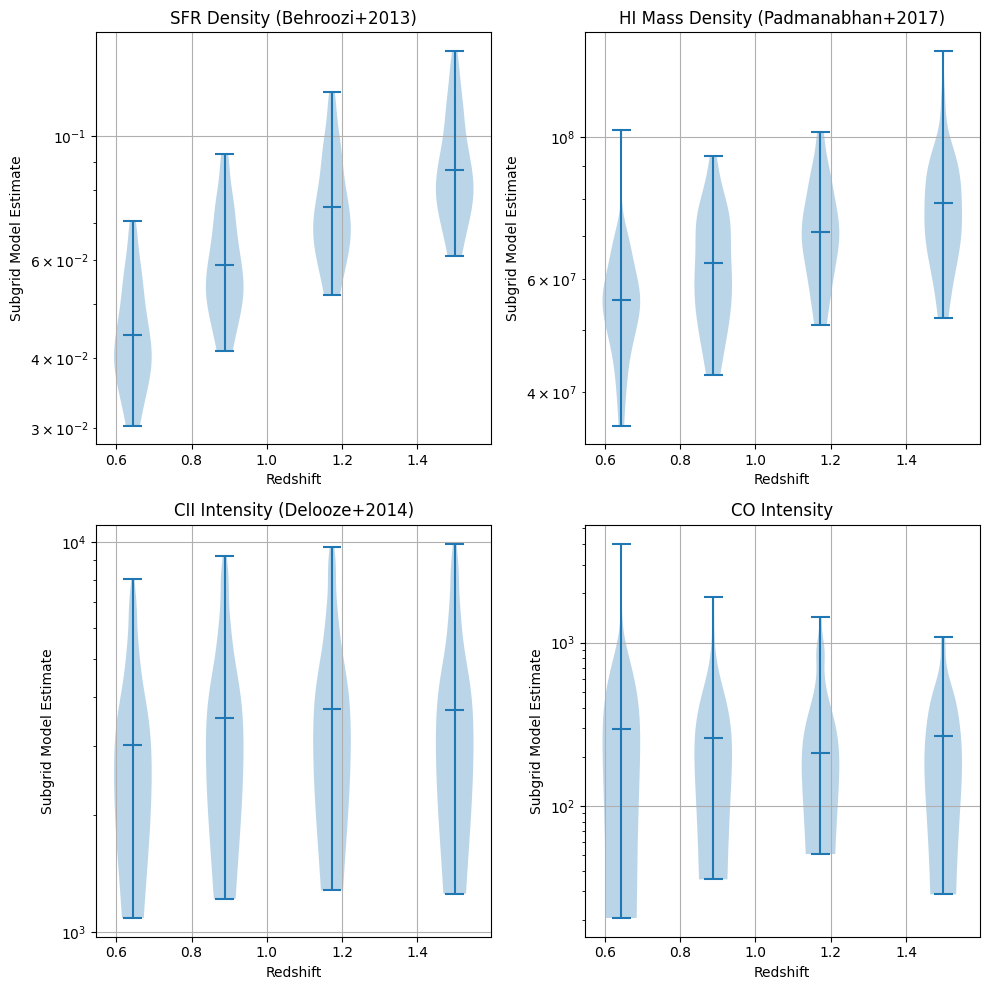

In [5]:
# make a violin plot of the densities
fig, axs = plt.subplots(2, 2, figsize=(10, 10))
axs = axs.flatten()
kwargs = {'showmedians': True, 'widths': 0.1, 'positions': Z_MODELING}

titles = ['SFR Density (Behroozi+2013)', 
        'HI Mass Density (Padmanabhan+2017)', 
        'CII Intensity (Delooze+2014)',
        'CO Intensity']

for ax, titl, vals in zip(axs, titles, [sfr_behroozi_density, mass_HI_density, mean_CII_intensity, mean_CO_intensity]):
    ax.violinplot(vals, **kwargs)
    ax.set_title(titl)
    ax.set_ylabel('Subgrid Model Estimate')
    ax.set_xlabel('Redshift')
    ax.grid(True)
    ax.set_yscale('log')

plt.tight_layout()
plt.show()

In [6]:
def rho_x(z, A, B, C, D):
    return (A * (1 + z) ** B) / (1 + ((1 + z) / C) ** D)

def rho_HI(z, A, B, C):
    return A * np.tanh(1 + z - B) + C

# Redshift range
z = np.linspace(ZMIN, ZMAX, 100)

# Parameters from the table
# params_rho_H2 = (1.00e7, 3.0, 2.3, 5.1)
# uncert_rho_H2 = (0.14e7, 0.6, 0.3, 0.5)

# params_rho_stars = (1.3e10, -4.1, 2.5, -3.8)
# uncert_rho_stars = (1.0e10, 0.4, 0.4, 0.3)

params_psi_stars = (0.0158, 2.88, 2.75, 5.88)
uncert_psi_stars = (0.0010, 0.16, 0.11, 0.15)

params_psi_starsMD = (0.0158, 2.7, 2.9, 5.6)

params_rho_HI = (4.5e7, 2.8, 1.01e8)
uncert_rho_HI = (0.5e7, 0.4, 0.07e8)

# Compute best-fit values
psi_stars_best = rho_x(z, *params_psi_stars)
rho_HI_best = rho_HI(z, *params_rho_HI)
psi_starsMD_best = rho_x(z, *params_psi_starsMD)

In [7]:
# sample psi stars and rho HI based on sigma in fits

np.random.seed(1511)  # for reproducibility

NSAMPLES = 1000
psi_stars_paras = np.random.normal(params_psi_stars, uncert_psi_stars, (NSAMPLES, len(params_psi_stars)))
rho_HI_paras = np.random.normal(params_rho_HI, uncert_rho_HI, (NSAMPLES, len(params_rho_HI)))

psi_stars = np.array([rho_x(z, *paras) for paras in psi_stars_paras])
rho_HIs = np.array([rho_HI(z, *paras) for paras in rho_HI_paras])

# get 1 sigma confidence intervals
percentiles = [16, 84]
psi_stars_lower = np.percentile(psi_stars, percentiles[0], axis=0)
psi_stars_upper = np.percentile(psi_stars, percentiles[1], axis=0)
rho_HI_lower = np.percentile(rho_HIs, percentiles[0], axis=0)
rho_HI_upper = np.percentile(rho_HIs, percentiles[1], axis=0)

In [8]:
import pickle

Agrawalzbins = [(.33, .86), (1.0, 1.6), (1.6, 2.3), (2.3, 2.9)]
InuCIIAgrawalbest = np.array([11.8, 11.0, 9.6, 9.2]) * 1e3
InuCIIAgrawalsig = np.array([10.2, 8.7, 9.8, 6.6]) * 1e3

shubh_fit = np.load('./data/A25_Inu_vs_z_behroozi_delooze.npz')
scatterdex = 0.2
amplitude_scaling = 3.20
amplitude_scaling_err = 1.12
A25fitInus = shubh_fit['fitInu'] * amplitude_scaling
A25zs = shubh_fit['zs']

with open('./data/Bethermin_line_background.p', 'rb') as f:
       b22data = pickle.load(f)
b22_CII_dL = b22data['line_background_MJy_sr'][:, -2] # MJy/sr
b22_freqs = b22data['freq']*1e9 # Hz
freq_cut = (b22_freqs < 1.47e12) & (b22_freqs > 0.211e12)
b22_zs = 1900.5369e9/b22_freqs - 1

with open('./data/ciihistorymodels.pkl', 'rb') as f:
    ciihistorymodels = pickle.load(f)
print(ciihistorymodels.keys())

from simim.galprops.log10normal import log10normal
behroozisfrfit = np.loadtxt('./data/behroozi13sfr.csv', delimiter=',')
behsfr_z, behsfr_psi = behroozisfrfit[:, 0], behroozisfrfit[:, 1]

# add .15 dex scatter
behsfr_psis = np.array([log10normal(behsfr_psi, 0.15, preserve_linear_mean=True) for _ in range(NSAMPLES)])
behsfr_psi_lower = np.percentile(behsfr_psis, percentiles[0], axis=0)
behsfr_psi_upper = np.percentile(behsfr_psis, percentiles[1], axis=0)

dict_keys(['Keenan et al 2024', 'Yang et al 2022', 'Padmanabhan et al 2019'])


In [9]:
# import data points
walterdata = np.loadtxt('./data/walter20rhohi.csv', delimiter=',', skiprows=1)
print(walterdata.shape)

MDdata = np.loadtxt('./data/MDsfr.csv', delimiter=',', skiprows=1)
print(MDdata.shape)

(39, 5)
(51, 5)


In [10]:
freq = [
    206.33333333, 208.43859649, 210.54385965, 212.64912281, 214.75438596,
    216.85964912, 218.96491228, 221.07017544, 223.1754386,  225.28070175,
    227.38596491, 229.49122807, 231.59649123, 233.70175439, 235.80701754,
    237.9122807,  240.01754386, 242.12280702, 244.22807018, 261.33333333,
    264.0, 266.66666667, 269.33333333, 272.0, 274.66666667,
    277.33333333, 280.0, 282.66666667, 285.33333333, 288.0,
    290.66666667, 293.33333333, 296.0, 298.66666667, 331.81818182,
    335.45454545, 339.09090909, 342.72727273, 346.36363636, 350.0,
    353.63636364, 357.27272727, 360.90909091, 364.54545455, 368.18181818,
    392.22222222, 396.66666667, 401.11111111, 405.55555556, 410.0,
    414.44444444, 418.88888889, 423.33333333, 427.77777778
]

co43 = [
    209.39520693, 195.96653632, 182.20509746, 182.73718973, 196.08938002,
    198.97554561, 185.59289349, 184.14712382, 169.18322099, 169.05520975,
    165.21194576, 164.69473422, 195.59186866, 197.24687903, 161.02545817,
    150.22994601, 169.94888182, 167.18476947, 141.76605684, 151.59568455,
    147.35781767, 164.64358444, 170.66103837, 144.09144889, 129.88914133,
    148.89114148, 156.85079374, 136.80142832, 142.57549197, 137.0145764,
    145.82898827, 166.64990685, 174.68513638, 156.33875744, 166.62334039,
    135.23820174, 100.85391351, 74.73554369, 56.56647224, 84.83002036,
    89.27282868, 86.60388527, 98.96074959, 100.83680786, 105.54611633,
    124.12817883, 116.76692608, 90.63539177, 78.10037827, 72.46120901,
    54.48776851, 77.01345668, 125.95007897, 106.00687634
]

co54 = [
    203.32322087, 197.92675833, 190.03019255, 194.98901987, 193.28507267,
    185.25297857, 197.20798842, 216.1058185,  209.61321162, 194.39842889,
    193.40843357, 174.59441772, 163.79336845, 171.44483528, 185.75937744,
    174.71712817, 157.51007967, 149.76431805, 152.85816595, 209.4056404,
    197.46799451, 206.27659646, 219.06067084, 206.34165922, 197.74268538,
    189.64264798, 177.82543181, 183.63384873, 171.28376981, 189.62246978,
    218.55230453, 187.33852265, 158.38578117, 169.29201937, 174.9538053,
    188.84925275, 168.29872409, 143.43970212, 162.61297527, 170.81778391,
    149.96326316, 152.12536258, 150.24938638, 166.42577113, 189.26166116,
    163.9876123,  170.56084405, 182.54590959, 203.08224234, 198.57416961,
    240.12048889, 215.95878321, 167.20215053, 130.16437382
]

# email from Christos Karoumpis

In [11]:
zVC = np.array([0.5, 1.0, 1.5, 2.0, 2.5, 3.0])
beff_auto = np.array([0.96, 1.31, 1.86, 2.53, 3.17, 3.47])
beff_auto_err = np.array([0.01, 0.01, 0.01, 0.01, 0.03, 0.03])
# from Van Cuyck Table A1

# from web plot digitizer
bCO43VC = [235.5053, 367.9873, 438.7235, 430.8830, 432.8299, 519.5318]
bCO43VCup = [269.6111, 430.8830, 493.2832, 484.4676, 483.3768, 559.6513]
bCO43VCdown = [200.2242, 305.8856, 379.7853, 379.7853, 379.7853, 475.8095]
CO43VC, CO43VCup, CO43VCdown = np.array(bCO43VC) / beff_auto, \
    np.array(bCO43VCup) / beff_auto, np.array(bCO43VCdown) / beff_auto

bCO54VC = [260.4095, 404.4080, 481.1766, 538.6673, 543.5531, 679.6634]
bCO54VCup = [317.6326, 443.6218, 541.1047, 614.0155, 608.4965, 762.5886]
bCO54VCdown = [198.6177, 360.4319, 412.7077, 459.9367, 481.1766, 612.6311]
CO54VC, CO54VCup, CO54VCdown = np.array(bCO54VC) / beff_auto, \
    np.array(bCO54VCup) / beff_auto, np.array(bCO54VCdown) / beff_auto

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_3452/2811626994.py:138: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


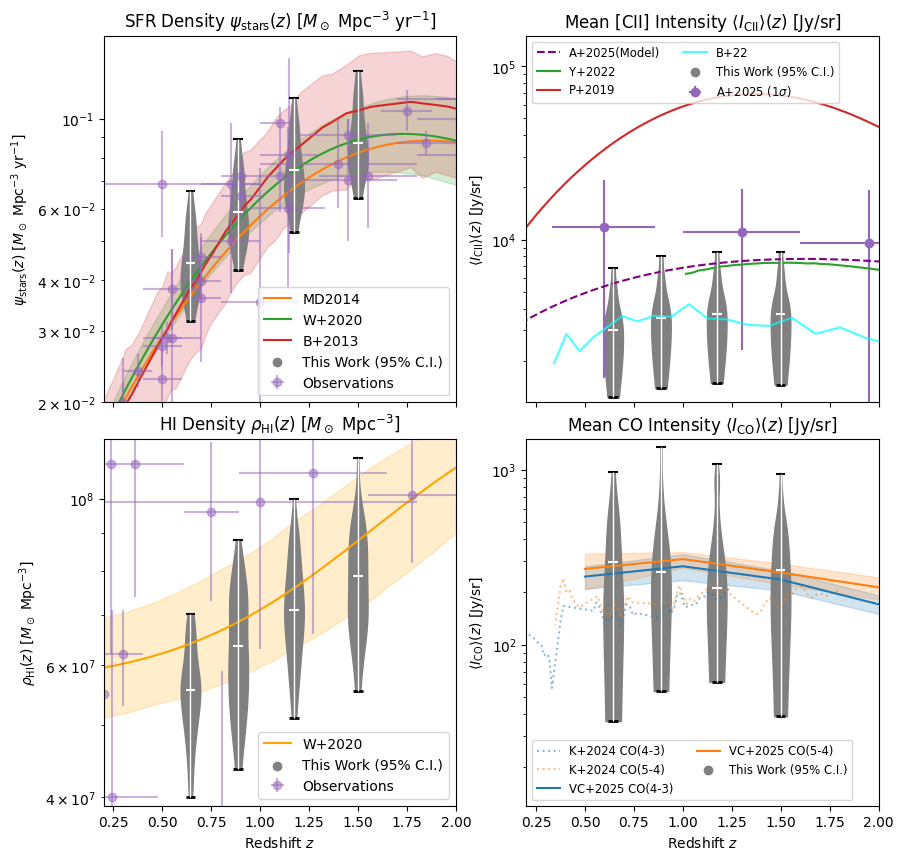

In [12]:
import simim.constants as sc

imffac = 0.63

# make a violin plot of the densities
fig, axs = plt.subplots(2, 2, figsize=(10, 10), gridspec_kw={'hspace': 0.1, 'wspace': 0.2}, sharex=True)
axs = axs.T.flatten()
kwargs = {'showmedians': True, 'widths': 0.1, 'positions': Z_MODELING}

# titles = ['SFR Density (Behroozi et al 2013)', 
#         'HI Mass Density (Padmanabhan et al 2017)', 
#         'CII Intensity (Delooze et al 2014)']

titles = [r'SFR Density $\psi_\text{stars}(z)$ [$M_\odot$ Mpc$^{-3}$ yr$^{-1}$]', 
        r'HI Density $\rho_\text{HI}(z)$ [$M_\odot$ Mpc$^{-3}$]',
        r'Mean [CII] Intensity $\langle I_\text{CII} \rangle(z)$ [Jy/sr]',
        r'Mean CO Intensity $\langle I_\text{CO} \rangle(z)$ [Jy/sr]']

for i, ax, titl, viovals in zip(range(len(axs)), axs, titles, [sfr_behroozi_density, mass_HI_density, mean_CII_intensity, mean_CO_intensity]):
    viovals = viovals.copy()
    ax.set_title(titl)
    ax.set_ylabel(titl[titl.index('$'):])
    if i % 2 == 1:
        ax.set_xlabel(r'Redshift $z$')
    # ax.grid(True)
    ax.set_yscale('log')
    ax.set_xlim(.2, ZMAX)
    if i == 0:
        # & Dickinson 
        ax.plot(z, psi_starsMD_best * imffac, label='MD2014', color='C1')
        ax.plot(z, psi_stars_best * imffac, label='W+2020', color='C2')
        ax.fill_between(z, psi_stars_lower * imffac, psi_stars_upper * imffac, color='C2', alpha=0.2)
        ax.plot(behsfr_z, behsfr_psi, label='B+2013', color='C3')
        ax.fill_between(behsfr_z, behsfr_psi_lower, behsfr_psi_upper, color='C3', alpha=0.2)
        ax.set_ylim(2e-2, 1.6e-1)
        
        label = 'Observations'
        for zmin,zmax,bestlogpsi,logpsierrlower,logpsierrupper in MDdata:
            yerr = [[(10**bestlogpsi - 10**(bestlogpsi - logpsierrlower)) * imffac], 
                    [(10**(bestlogpsi + logpsierrupper) - 10**bestlogpsi) * imffac]]
            ax.errorbar((zmin+zmax)/2, 10**np.array(bestlogpsi) * imffac, yerr=np.array(yerr), 
                        xerr=[[ (zmax - zmin)/2 ], [ (zmax - zmin)/2 ]], 
                        fmt='o', color='C4', alpha=0.5, label=label)
            label = None  # only label the first point
        
    elif i == 1:
        ax.plot(z, rho_HI_best, label='W+2020', color='orange')
        ax.fill_between(z, rho_HI_lower, rho_HI_upper, color='orange', alpha=0.2)
        ax.set_ylim(3.9e7, 1.2e8)
        
        label = 'Observations'
        for zmin,zmax,bestrho,rhoerrlower,rhoerrupper in walterdata:
            ax.errorbar((zmin+zmax)/2, 1e8*bestrho, 
                        yerr=[[1e8*rhoerrlower], [1e8*rhoerrupper]], 
                        xerr=[[ (zmax - zmin)/2 ], [ (zmax - zmin)/2 ]], 
                        fmt='o', color='C4', alpha=0.5, label=label)
            label = None  # only label the first point
        
    elif i == 2:
        zmeds = [(zb[0] + zb[1]) / 2 for zb in Agrawalzbins]
        ax.errorbar(zmeds, 
                    InuCIIAgrawalbest, 
                    yerr=InuCIIAgrawalsig, 
                    xerr=([zmed - zb[0] for zb, zmed in zip(Agrawalzbins, zmeds)],
                            [zb[1] - zmed for zb, zmed in zip(Agrawalzbins, zmeds)]),
                    fmt='o', 
                    label=r'A+2025 ($1\sigma$)', 
                    color='C4')
        
        ax.plot(A25zs, A25fitInus, label='A+2025(Model)', color='purple', ls = "--")
        # ax.set_ylim(1e3, 3e4)
        ax.set_ylim(1.15e3, 1.5e5)
        for i, (label, (zs, vals)) in enumerate(ciihistorymodels.items()):
            label = label.split(" ")
            label[0] = label[0][0] # keep only first initial
            label = " ".join(label)
            label = label.replace(' et al ', '+')
            if "K" in label:
                continue
                ax.fill_between(zs, vals[0], vals[1], 
                                color=f'C{i+1}', alpha=0.2, label=label)
            else:
                ax.plot(zs, vals, 
                        color=f'C{i+1}', alpha=1, label=label)
        ax.plot(b22_zs[freq_cut], 1e6*b22_CII_dL[freq_cut], color='cyan', label='B+22', alpha=0.7)
    
    elif i == 3:
        z_CO43 = sc.nu_co43 / (np.array(freq) * 1e9) - 1
        z_CO54 = sc.nu_co54 / (np.array(freq) * 1e9) - 1
        ax.plot(z_CO43 , co43, label='K+2024 CO(4-3)', color='C0', alpha=0.5, ls=":")
        ax.plot(z_CO54, co54, label='K+2024 CO(5-4)', color='C1', alpha=0.5, ls=":")
        
        ax.plot(zVC, CO43VC, color='C0', label='VC+2025 CO(4-3)')
        ax.fill_between(zVC, CO43VCdown, CO43VCup, color='C0', alpha=0.2)
        ax.plot(zVC, CO54VC, color='C1', label='VC+2025 CO(5-4)')
        ax.fill_between(zVC, CO54VCdown, CO54VCup, color='C1', alpha=0.2)
        ax.set_ylim(1.2e1, 1.5e3)
    
    # # keep N sigma limits within plot range
    # sigma_cut = [1.96, 1.96, 2.576][i]
    # viovals_med = [np.median(v) for v in viovals]
    viovals_upp = [np.percentile(v, 97.5) for v in viovals]
    viovals_low = [np.percentile(v, 2.5) for v in viovals]
    # viovals_std = [np.std(v) for v in viovals]
    viovals_new = []
    for j in range(len(viovals)):
        # upper_limit = viovals_med[j] + sigma_cut * viovals_std[j]
        # lower_limit = viovals_med[j] - sigma_cut * viovals_std[j]
        upper_limit = viovals_upp[j]
        lower_limit = viovals_low[j]
        viovals_new.append(viovals[j][(viovals[j] <= upper_limit) & (viovals[j] >= lower_limit)])
    
    if i == 2:
        viovals_new = [v for v in viovals_new]
    
    parts = ax.violinplot(viovals_new, **kwargs)
    for pc in parts['bodies']:
        pc.set_facecolor("grey")
        pc.set_edgecolor('grey')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('white')
    parts['cbars'].set_edgecolor('white')
    parts['cmins'].set_edgecolor('black')
    parts['cmaxes'].set_edgecolor('black')
    parts['cbars'].set_linewidth(1)
    parts['cmins'].set_linewidth(2)
    # add a label for the violins with hack
    _ = ax.scatter([], [], color='grey', label='This Work (95% C.I.)')
    
    if i == 2:
        # ax.legend(fontsize='medium', loc='upper left')
        ax.legend(fontsize='small', ncol=2, loc='upper left')
    elif i == 3:
        ax.legend(fontsize='small', ncol=2)
    else:
        ax.legend(fontsize='medium')

plt.tight_layout()
# plt.savefig('../figs/validation_violins.pdf', dpi=300)
plt.show()
plt.close()

In [13]:
YKCdata = np.loadtxt('./data/YKC-I_nu_cosmic_CO_CII.ecsv', delimiter=',', comments='#')
# z,CII_nu,CII_I_nu,CII_I_nu_low,CII_I_nu_up,CO_10_nu,CO_10_I_nu,CO_10_I_nu_low,CO_10_I_nu_up,CO_21_nu,CO_21_I_nu,CO_21_I_nu_low,CO_21_I_nu_up,CO_32_nu,CO_32_I_nu,CO_32_I_nu_low,CO_32_I_nu_up,CO_43_nu,CO_43_I_nu,CO_43_I_nu_low,CO_43_I_nu_up,CO_54_nu,CO_54_I_nu,CO_54_I_nu_low,CO_54_I_nu_up,CO_65_nu,CO_65_I_nu,CO_65_I_nu_low,CO_65_I_nu_up,CO_76_nu,CO_76_I_nu,CO_76_I_nu_low,CO_76_I_nu_up,CO_87_nu,CO_87_I_nu,CO_87_I_nu_low,CO_87_I_nu_up,CO_98_nu,CO_98_I_nu,CO_98_I_nu_low,CO_98_I_nu_up
YKCdataz = YKCdata[:, 0]
YKCdata_CII_I_nu, YKCdata_CII_I_nu_low, YKCdata_CII_I_nu_up = YKCdata[:, 2], YKCdata[:, 3], YKCdata[:, 4]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_3452/1047878965.py:90: UserWarning: This figure includes Axes that are not compatible with tight_layout, so results might be incorrect.
  plt.tight_layout()


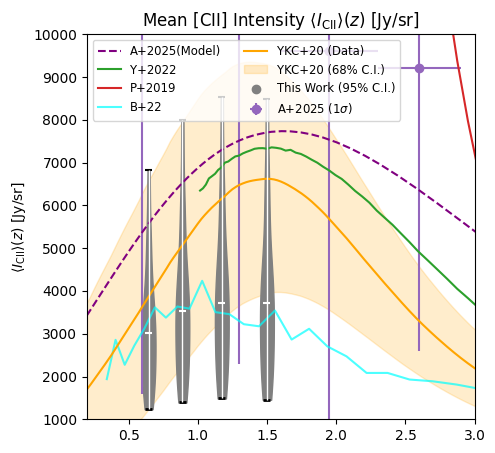

In [16]:
import simim.constants as sc

imffac = 0.63

fig, axs = plt.subplots(1, 1, figsize=(5, 5), gridspec_kw={'hspace': 0.1, 'wspace': 0.2}, sharex=True)
kwargs = {'showmedians': True, 'widths': 0.1, 'positions': Z_MODELING}

titles = [r'Mean [CII] Intensity $\langle I_\text{CII} \rangle(z)$ [Jy/sr]']

for i, ax, titl, viovals in zip(range(len([axs])), [axs], titles, [mean_CII_intensity]):
    viovals = viovals.copy()
    ax.set_title(titl)
    ax.set_ylabel(titl[titl.index('$'):])
    if i % 2 == 1:
        ax.set_xlabel(r'Redshift $z$')
    # ax.grid(True)
    # ax.set_yscale('log')
    ax.set_xlim(.2, 3)
    
    zmeds = [(zb[0] + zb[1]) / 2 for zb in Agrawalzbins]
    ax.errorbar(zmeds, 
                InuCIIAgrawalbest, 
                yerr=InuCIIAgrawalsig, 
                xerr=([zmed - zb[0] for zb, zmed in zip(Agrawalzbins, zmeds)],
                        [zb[1] - zmed for zb, zmed in zip(Agrawalzbins, zmeds)]),
                fmt='o', 
                label=r'A+2025 ($1\sigma$)', 
                color='C4')
    
    ax.plot(A25zs, A25fitInus, label='A+2025(Model)', color='purple', ls = "--")
    ax.set_ylim(1e3, 1e4)
    # ax.set_ylim(1e3, 1.5e5)
    for i, (label, (zs, vals)) in enumerate(ciihistorymodels.items()):
        label = label.split(" ")
        label[0] = label[0][0] # keep only first initial
        label = " ".join(label)
        label = label.replace(' et al ', '+')
        if "K" in label:
            continue
            ax.fill_between(zs, vals[0], vals[1], 
                            color=f'C{i+1}', alpha=0.2, label=label)
        else:
            ax.plot(zs, vals, 
                    color=f'C{i+1}', alpha=1, label=label)
    ax.plot(b22_zs[freq_cut], 1e6*b22_CII_dL[freq_cut], color='cyan', label='B+22', alpha=0.7)
    
    # YKC data points
    ax.plot(YKCdataz, YKCdata_CII_I_nu, color='orange', label='YKC+20 (Data)')
    ax.fill_between(YKCdataz, YKCdata_CII_I_nu_low, YKCdata_CII_I_nu_up, color='orange', alpha=0.2, label='YKC+20 (68% C.I.)')
    
    
    # # keep N sigma limits within plot range
    # sigma_cut = [1.96, 1.96, 2.576][i]
    # viovals_med = [np.median(v) for v in viovals]
    viovals_upp = [np.percentile(v, 97.5) for v in viovals]
    viovals_low = [np.percentile(v, 2.5) for v in viovals]
    # viovals_std = [np.std(v) for v in viovals]
    viovals_new = []
    for j in range(len(viovals)):
        # upper_limit = viovals_med[j] + sigma_cut * viovals_std[j]
        # lower_limit = viovals_med[j] - sigma_cut * viovals_std[j]
        upper_limit = viovals_upp[j]
        lower_limit = viovals_low[j]
        viovals_new.append(viovals[j][(viovals[j] <= upper_limit) & (viovals[j] >= lower_limit)])
    
    viovals_new = [v for v in viovals_new]
    
    parts = ax.violinplot(viovals_new, **kwargs)
    for pc in parts['bodies']:
        pc.set_facecolor("grey")
        pc.set_edgecolor('grey')
        pc.set_alpha(1)
    parts['cmedians'].set_edgecolor('white')
    parts['cbars'].set_edgecolor('white')
    parts['cmins'].set_edgecolor('black')
    parts['cmaxes'].set_edgecolor('black')
    parts['cbars'].set_linewidth(1)
    parts['cmins'].set_linewidth(2)
    # add a label for the violins with hack
    _ = ax.scatter([], [], color='grey', label='This Work (95% C.I.)')
    
    if i == 2:
        # ax.legend(fontsize='medium', loc='upper left')
        ax.legend(fontsize='small', ncol=2, loc='upper left')
    elif i == 3:
        ax.legend(fontsize='small', ncol=2)
    else:
        ax.legend(fontsize='medium')

plt.tight_layout()

plt.show()
plt.close()

In [90]:
import numpy as np
import matplotlib.pyplot as plt
from astropy import constants as cst, units as u

Z_MODELING = [.32, .44]
ZIDX = 0
FILENAME = lambda z: f'../outs/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'

In [91]:
data = np.load(FILENAME(Z_MODELING[ZIDX]), allow_pickle=True)

ks = data['k']
pshi = data['ps_hi'] * u.Jy**2 * u.Mpc**3
lambda_hi = .21 * u.m
z = data['z_modeling']
lobs = lambda_hi * (1 + z)

pshi = ((pshi * (lobs ** 2 / 2 / cst.k_B) ** 2) / (u.mK**2 * u.Mpc**3)).decompose().value

FileNotFoundError: [Errno 2] No such file or directory: '../outs/0.32/power_spectra_ensemble_0.32.npz'

In [ ]:
paul23data = np.loadtxt(f'./data/paul23_z_{z:.2f}.csv', delimiter=',', skiprows=1)
p23ks, p23pshi, p23err = paul23data[:,0], paul23data[:,1], paul23data[:,2]

In [ ]:
from scipy.interpolate import interp1d

pshimedian = np.median(pshi, axis=0)
pshilow = np.percentile(pshi, 16, axis=0)
pshiup = np.percentile(pshi, 84, axis=0)

masknans = np.isfinite(pshimedian) & np.isfinite(pshilow) & np.isfinite(pshiup)
logfit = interp1d(ks[masknans], np.log10(pshimedian[masknans]), kind='cubic', fill_value='extrapolate')

# curve fit for amplitude scaling
from scipy.optimize import curve_fit
def func(ks, A):
    return A * 10 ** logfit(ks)

popt, pcov = curve_fit(func, p23ks, p23pshi, sigma=p23err, absolute_sigma=True, p0=[5.0])
perr = np.sqrt(np.diag(pcov))
print("Best-fit amplitude scaling A = ", popt[0], "+/-", perr[0])

Best-fit amplitude scaling A =  2.04914564422336 +/- 0.28695533084011404


In [ ]:
np.savetxt(f'./forjames_paulzs_{z:.2f}.csv', np.array([ks, pshimedian, pshilow, pshiup]).T, delimiter=',', header='k, P(k)_50, P(k)_16, P(k)_84', comments='')

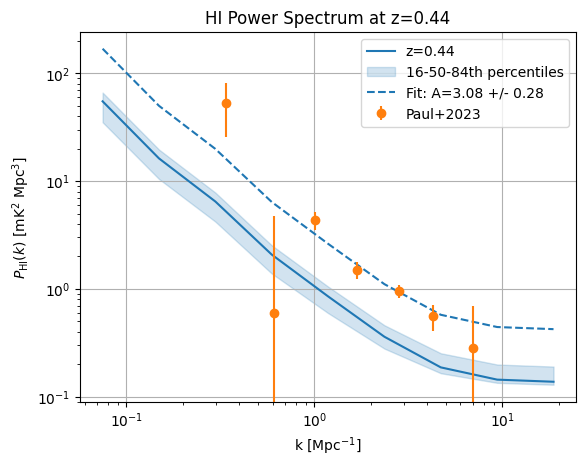

In [ ]:
plt.figure()
plt.loglog(ks, pshimedian, label=f'z={z:.2f}')
plt.fill_between(ks, pshilow, pshiup, color='C0', alpha=0.2, label='16-50-84th percentiles')
plt.loglog(ks[masknans], func(ks[masknans], *popt), '--', color='C0', label=f'Fit: A={popt[0]:.2f} +/- {perr[0]:.2f}')
plt.errorbar(p23ks, p23pshi, yerr=p23err, fmt='o', color='C1', label='Paul+2023')
plt.title(f'HI Power Spectrum at z={z:.2f}')
plt.xlabel('k [Mpc$^{-1}$]')
plt.ylabel(r'$P_\text{HI}(k)$ [mK$^2$ Mpc$^3$]')
plt.legend()
plt.grid()
plt.show()
plt.close()

In [23]:
import pickle
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys
from astropy.cosmology import Planck18 as cosmo
h = cosmo.h

cross_exps = {}
with open('./outs/CIIexps.pkl', 'rb') as f:
    CIIexps = pickle.load(f)
with open('./outs/GALexps.pkl', 'rb') as f:
    GALexps = pickle.load(f)

print(CIIexps.keys())
print(GALexps.keys())
cross_exps = {}

dict_keys(['PTIM_1', 'TIM_NG', 'SpTIM_100'])
dict_keys(['Euclid_100', 'Euclid_4', 'Euclid_1'])


In [24]:
combos = [
    ('PTIM_1', 'Euclid_1'),
    ('TIM_NG', 'Euclid_4'),
    ('SpTIM_100', 'Euclid_100')]


bands = ['SW', 'SW', 'LW', 'LW']

Z_MODELING = [0.644, 0.888, 1.173, 1.499]
FILENAME = lambda z: f'../outs/new/{z:.2f}/power_spectra_ensemble_{z:.2f}.npz'
datas = []
for Z in Z_MODELING:
    with open(FILENAME(Z), 'rb') as f:
        data = pickle.load(f)
        datas.append(data)

KSs = [data['k'] for data in datas]
psCIIxCO = [data['ps_cross_ciixgalaxy'] for data in datas]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCIIxCOmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCIIxCO]

In [25]:
for cii_key, co_key in combos:
    KSs_cii, psCII_cii, Pstd_cii, binned_total_cii, Nmodes_cii, Pn_cii, binned_wbeams_cii, binned_whpfs_cii, label_cii = CIIexps[cii_key]
    KSs_co, psCO_co, Pstd_co, binned_total_co, Nmodes_co, Pn_co, binned_wbeams_co, binned_whpfs_co, label_co = GALexps[co_key]
    
    # Nmodes = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes_kmu = [np.minimum(NmodeCII, NmodesCO) for NmodeCII, NmodesCO in zip(Nmodes_cii, Nmodes_co)]
    Nmodes = [np.sum(Nmodes_kmu_i, axis=0) for Nmodes_kmu_i in Nmodes_kmu]
    # do not apply window for galaxy survey
    Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \
        zip(psCIIxCOmedian, psCII_cii, Pn_cii, binned_total_cii, psCO_co, Pn_co, binned_total_co, Nmodes)]
    Pstd = [np.sqrt(pv) for pv in Pvar]
    
    cross_exps[f'{cii_key} x {co_key}'] = (KSs, psCIIxCOmedian, Pstd, Nmodes, Pn_cii, Pn_co, label_cii + ' x ' + label_co)

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_14961/3949055607.py:9: RuntimeWarning: divide by zero encountered in divide
  Pvar = [(pcross ** 2 + (p1 + pn1 / w1) * (p2 + pn2)) / Nmode / 2 for pcross, p1, pn1, w1, p2, pn2, w2, Nmode in \


In [26]:
with open('./data/TIMxGal_preds/TIMxEuclid_results.pkl', 'rb') as f:
    TIMxGal_results = pickle.load(f)
with open('./data/TIMxGal_preds/TIM2xEuclid_results.pkl', 'rb') as f:
    TIM2xGal_results = pickle.load(f)

In [27]:
TIMxGal_results.keys()

dict_keys(['PxGs', 'VARx', 'x_shots', 'Plls', 'NTIMs', 'ICiis', 'nEffs', 'SNR_PxG', 'quad_SNRs', 'aligned_PxGs', 'aligned_SNRs', 'aligned_x_noises', 'k_modes', 'matter_power', 'cVars'])

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_14961/408970685.py:54: UserWarning: Tight layout not applied. tight_layout cannot make Axes width small enough to accommodate all Axes decorations
  plt.tight_layout()


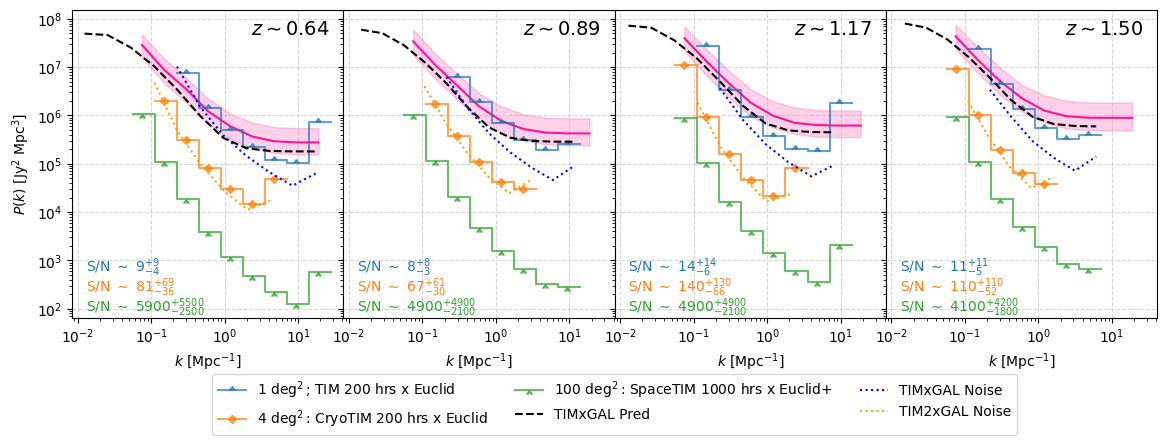

In [35]:
percentiles = [16, 50, 84]
pslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCIIxCO]
psup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCIIxCO]

fig, axs = plt.subplots(1, 4, figsize=(14, 4), sharex=True, sharey=True, gridspec_kw={'wspace': 0, 'hspace': 0})
axs = axs.flatten()
PSCOLOR = 'deeppink' #'orange'  #'cyan'
markers = [10, 'D', 6]

labels = [
    r"1 $\deg^2$; TIM 200 hrs x Euclid",
    r"4 $\deg^2$: CryoTIM 200 hrs x Euclid",
    r"100 $\deg^2$: SpaceTIM 1000 hrs x Euclid+"
]

for ax in axs:
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.grid(linestyle='--', alpha=0.5)

axs[0].set_ylabel(r'$P(k)$ [Jy$^2$ Mpc$^3$]')

for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], pslow[i], psup[i], color=PSCOLOR, alpha=0.2)
    ax.plot(KSs[i][1:-1], psCIIxCOmedian[i], color=PSCOLOR)
        
    for j, exp in enumerate(cross_exps.values()):
        KSs_exp, psCIIxCO_exp, Pstd_exp, Nmodes_exp, Pn1_exp, Pn2_exp, label = exp
        _ = ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=labels[j], marker=markers[j], markersize=4, alpha=0.7)
        SNR = psCIIxCO_exp[i] / Pstd_exp[i]
        SNRlow, SNRhigh = pslow[i] / Pstd_exp[i], psup[i] / Pstd_exp[i]
        SNR, SNRlow, SNRhigh = np.nansum(SNR), np.nansum(SNRlow), np.nansum(SNRhigh)
        SNRlow, SNRhigh = SNR - SNRlow, SNRhigh - SNR
        SNR, SNRlow, SNRhigh = [int(float('%.2g' % s)) if 1e1 else "%s" % float('%.2g' % s) for s in (SNR, SNRlow, SNRhigh)]
                
        snrtext = r'S/N $\sim$ ' + f'{SNR}' + f'$_{{-{SNRlow}}}^{{+{SNRhigh}}}$'
        ax.text(.05, .15-.065*j, snrtext, color=f'C{j}', transform=ax.transAxes)
    ax.text(.95, .92, r'$z \sim$' f'{Z_MODELING[i]:.2f}', transform=ax.transAxes, horizontalalignment='right', fontsize=14)
    
    TxG_PxG = TIMxGal_results['PxGs'][i]
    TxG_VarX = TIMxGal_results['VARx'][i]
    TxG_ks = TIMxGal_results['k_modes'][i]# / h
    ax.plot(TxG_ks, TxG_PxG, color='black', ls='--', label='TIMxGAL Pred')
    ax.plot(TxG_ks, np.sqrt(TxG_VarX), color='blue', ls=':', label='TIMxGAL Noise')
    
    T2xG_PxG = TIM2xGal_results['PxGs'][i]
    T2xG_VarX = TIM2xGal_results['VARx'][i]
    T2xG_ks = TIM2xGal_results['k_modes'][i]# / h
    ax.plot(T2xG_ks, np.sqrt(T2xG_VarX), color='orange', ls=':', label='TIM2xGAL Noise')

axs[0].legend(bbox_to_anchor=(2, -.16), loc='upper center', fontsize=10, ncol=3)

plt.tight_layout()
plt.show()
plt.close()

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.cosmology import Planck18 as cosmo
from astropy import units as u, constants as cst
import os, sys

COexps = {}

sys.path.append(os.getcwd() + '/../camb')
import utils as ut
import props as p
import lines as l
from importlib import reload
p = reload(p)

from astropy.cosmology import Planck18 as cosmo
H0 = cosmo.H0.value
h = cosmo.h
lilh = False

FYST = p.FYST
TIM = p.TIM

FPI_factor = 40 # 315-210 / 2.6

TIM.Daz = 2 * u.deg
TIM.Del = 2 * u.deg
FYST.time = 2000 * u.hr / FPI_factor

In [36]:
# TIM
bins = [
    ut.zBin(5.5, 6.5)
]

bands = ['CO43']

LSbins = [ut.Survey(b, FYST[band].ins, TIM.Daz, TIM.Del, lilh) for b, band in zip(bins, bands)]

k_xyz_modes = [lsb.k_modes() for lsb in LSbins]
# k_xyz_modes[N] where N is the survey bin
# each element is a 4D array of shape (3, Nkx, Nky, Nkz)

k_mags = [np.sqrt(np.sum(kxyzs**2, axis=0)) for kxyzs in k_xyz_modes] 
k_mins = [np.min(km[km != 0]) for km in k_mags]
k_maxs = [np.max(km) for km in k_mags]
k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]

# parallel and perpendicular components
k_para = [np.abs(kxyzs[2]) for kxyzs in k_xyz_modes]
k_perp = [np.sqrt(kxyzs[0]**2 + kxyzs[1]**2) for kxyzs in k_xyz_modes]
kxs = [kxyzs[0] for kxyzs in k_xyz_modes]
kys = [kxyzs[1] for kxyzs in k_xyz_modes]
kzs = [kxyzs[2] for kxyzs in k_xyz_modes]

kxmins = [np.min(abs(kx[kx != 0])) for kx in kxs]
kxmaxs = [np.max(abs(kx)) for kx in kxs]
kymins = [np.min(abs(ky[ky != 0])) for ky in kys]
kymaxs = [np.max(abs(ky)) for ky in kys]
kzmins = [np.min(abs(kz[kz != 0])) for kz in kzs]
kzmaxs = [np.max(abs(kz)) for kz in kzs]

# mu = cos theta
mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]

/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_34884/3432731763.py:17: RuntimeWarning: invalid value encountered in divide
  k_props = [np.abs(kxyzs / km) for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_34884/3432731763.py:34: RuntimeWarning: invalid value encountered in divide
  mu = muz = [kxyzs[2] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_34884/3432731763.py:35: RuntimeWarning: invalid value encountered in divide
  mux = [kxyzs[0] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]
/var/folders/q2/wnqqn8090kl5jt226qvshg1h0000gn/T/ipykernel_34884/3432731763.py:36: RuntimeWarning: invalid value encountered in divide
  muy = [kxyzs[1] / km for kxyzs, km in zip(k_xyz_modes, k_mags)]


In [37]:
def sig_xy(z, insFWHM):
    sigbeam = insFWHM.to(u.rad).value / np.sqrt(8 * np.log(2))
    return (cosmo.comoving_distance(z) * sigbeam).to(u.Mpc).value

def sig_z(z, insdnu, linenu):
    return (cst.c / cosmo.H(z) * insdnu / linenu * (1 + z) ** 2).to(u.Mpc).value / np.sqrt(8 * np.log(2))

def L_z(z, insmin, insmax, linenu):
    if insmin.unit.is_equivalent(u.m):
        insmin = cst.c / insmin
        insmax = cst.c / insmax
    Dnu = np.abs(insmax - insmin)
    return (cst.c / cosmo.H(z) * Dnu / linenu * (1 + z) ** 2).to(u.Mpc).value

def L_xy(z, insAng):    
    return ((cosmo.comoving_distance(z) * insAng.to(u.rad).value)).to(u.Mpc).value

def kminz(z, insmin, insmax, linenu):
    return 2 * np.pi / L_z(z, insmin, insmax, linenu)

def kminxy(z, insAng):
    return 2 * np.pi / L_xy(z, insAng)

def wbeam_m(km, sigm):
    return np.exp(-0.5 * (km * sigm)**2)

def wbeam(ks, sigs):
    return np.prod([wbeam_m(k, s) for k, s in zip(ks, sigs)], axis=0)

def whpf_m(km, km_min):
    return (1 - np.exp(- (km/km_min) ** 2)) ** 0.5

def whpf(ks, km_mins):
    return np.prod([whpf_m(k, km_min) for k, km_min in zip(ks, km_mins)], axis=0)

insFWHMs = [FYST[band].FWHM for band in bands]
insAng_x, insAng_y = TIM.Daz, TIM.Del
insmins = [FYST[band].min for band in bands]
insmaxs = [FYST[band].max for band in bands]
insdnus = [FYST.dnu for band in bands]
linenus = [l.CII.nu]
CALCZs = [b.center for b in bins]

sigxs = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigys = [sig_xy(CALCZ, insFWHM) for CALCZ, insFWHM in zip(CALCZs, insFWHMs)]
sigzs = [sig_z(CALCZ, insdnu, linenu) for CALCZ, insdnu, linenu in zip(CALCZs, insdnus, linenus)]

kminxs = [kminxy(CALCZ, insAng_x) for CALCZ in CALCZs]
kminys = [kminxy(CALCZ, insAng_y) for CALCZ in CALCZs]
kminzs = [kminz(CALCZ, insmin, insmax, linenu) for CALCZ, insmin, insmax, linenu in zip(CALCZs, insmins, insmaxs, linenus)]

wbeamxs = [wbeam_m(kx, sigx) for kx, sigx in zip(kxs, sigxs)]
wbeamys = [wbeam_m(ky, sigy) for ky, sigy in zip(kys, sigys)]
wbeamzs = [wbeam_m(kz, sigz) for kz, sigz in zip(kzs, sigzs)]
wbeams = [wbeam([kx, ky, kz], [sigx, sigy, sigz]) for kx, ky, kz, sigx, sigy, sigz in zip(kxs, kys, kzs, sigxs, sigys, sigzs)]

whpfxs = [whpf_m(kx, kminx) for kx, kminx in zip(kxs, kminxs)]
whpfys = [whpf_m(ky, kminy) for ky, kminy in zip(kys, kminys)]
whpfzs = [whpf_m(kz, kminz) for kz, kminz in zip(kzs, kminzs)]
whpfs = [whpf([kx, ky, kz], [kminx, kminy, kminz]) for kx, ky, kz, kminx, kminy, kminz in zip(kxs, kys, kzs, kminxs, kminys, kminzs)]

wtotal = [wb * wh for wb, wh in zip(wbeams, whpfs)]

In [38]:
import camb

# model matter power spectrum at z ~ 6
z_eval = 6.0
cosmo_params = camb.CAMBparams()
cosmo_params.set_cosmology(H0=cosmo.H0.value, ombh2=cosmo.Ob0 * cosmo.h**2, omch2=cosmo.Odm0 * cosmo.h**2, mnu=0.06, omk=0, tau=0.06)
cosmo_params.InitPower.set_params(ns=0.965, r=0)
cosmo_params.set_matter_power(redshifts=[z_eval], kmax=10.0)
cosmo_params.NonLinear = camb.model.NonLinear_both
results = camb.get_results(cosmo_params)
kh, zc, pk = results.get_matter_power_spectrum(minkh=1e-1, maxkh=1e1, npoints=21)

# make b_cii~8, i_cii~100 Jy sr-1, and P_shot~3e7 Jy2 sr-2 Mpc3
pkcii = pk * (8.0 ** 2) * (100.0 ** 2) + 3e7

In [39]:
def Pn_single(NEI, t_surv, N_spax, z, Daz, Del, dnuFWHM, nu_rest):
    A_surv = (Daz * Del).to(u.sr).value
    dnu = dnuFWHM / np.sqrt(8 * np.log(2))
    chi = cosmo.comoving_distance(z)
    dchi_dnu = cst.c / cosmo.H(z) * (1 + z) ** 2 / nu_rest
    Pn = NEI**2 / t_surv / N_spax * chi**2 * dchi_dnu * A_surv * dnu
    return Pn.to(u.Jy**2 * u.Mpc**3).value

In [75]:
KSs = [kh * h for _ in CALCZs]
psCOs = [pkcii for _ in CALCZs]
kbinedges = [(KS[:-1] * KS[1:])**0.5 for KS in KSs]

psCOsmedian = [np.median(pscii, axis=0)[1:-1] for pscii in psCOs]

binnedidxs = [np.digitize(km.flat, kbinedge) - 1 for km, kbinedge in zip(k_mags, kbinedges)]

binned_wbeams = [np.array([np.mean(wbeam.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wbeam, binnedidx in zip(kbinedges, wbeams, binnedidxs)]
binned_whpfs = [np.array([np.mean(whpf.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, whpf, binnedidx in zip(kbinedges, whpfs, binnedidxs)]
binned_total = [np.array([np.mean(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for kbinedge, wtotal, binnedidx in zip(kbinedges, wtotal, binnedidxs)]

FYST_NEI = FYST.NEI * np.sqrt(FYST.nbeams / 0.8)
Pns = [Pn_single(FYST_NEI * u.sr, FYST.time, FYST.nbeams, CALCZ, TIM.Daz, TIM.Del, FYST.dnu, linenu) for CALCZ, linenu in zip(CALCZs, linenus)]

Nmodes = [np.array([np.sum(wtotal.flat[binnedidx == i]) for i in range(len(kbinedge) - 1)]) for wtotal, binnedidx, kbinedge in zip(wtotal, binnedidxs, kbinedges)]
Nmodes_ones = [np.array([np.sum(binnedidx == i) for i in range(len(kbinedge) - 1)]) for binnedidx, kbinedge in zip(binnedidxs, kbinedges)]

# count 1 if all components are non-zero, 0 otherwise
Nmodes_Z = [np.array([np.sum((kxs[i].flat[binnedidxs[i] == j] != 0) & (kys[i].flat[binnedidxs[i] == j] != 0) & (kzs[i].flat[binnedidxs[i] == j] != 0)) \
    for j in range(len(kbinedges[i]) - 1)]) for i in range(len(binnedidxs))]

/Users/shubh/miniconda3/envs/lim/lib/python3.11/site-packages/numpy/core/fromnumeric.py:3504: RuntimeWarning: Mean of empty slice.
  return _methods._mean(a, axis=axis, dtype=dtype,
/Users/shubh/miniconda3/envs/lim/lib/python3.11/site-packages/numpy/core/_methods.py:129: RuntimeWarning: invalid value encountered in scalar divide
  ret = ret.dtype.type(ret / rcount)


In [76]:
# Pvar = [(ps + Pn / bw) ** 2 / Nmode for ps, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes)]
# Pvar = [(ps + Pn) ** 2 / Nmode for ps, Pn, Nmode in zip(psCOsmedian, Pns, Nmodes_ones)]
Pvar = [(psCII + Pn / bw) ** 2 / Nmode for psCII, Pn, bw, Nmode in zip(psCOsmedian, Pns, binned_total, Nmodes_Z)]

Pstd = [np.sqrt(pv) for pv in Pvar] 

In [77]:
# COexps['EoRSpecCII'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, \
#     r'EoRSpec 4 $\deg^2$, 2000 hours, ' f'FYST_NEI ~ {FYST_NEI.to(u.Jy * u.s ** 0.5 / u.sr).value/1e3:.0f}' r'kJy s$^{{-1/2}}$ sr$^{{-1}}$')
COexps['EoRSpecCIIsqrt'] = (KSs, psCOsmedian, Pstd, binned_total, Nmodes, Pns, binned_wbeams, binned_whpfs, \
    r'EoRSpec 4 $\deg^2$, 2000 hours, ' f'FYST_NEI ~ {FYST_NEI.to(u.Jy * u.s ** 0.5 / u.sr).value/1e3:.0f}' r'kJy s$^{{-1/2}}$ sr$^{{-1}}$')


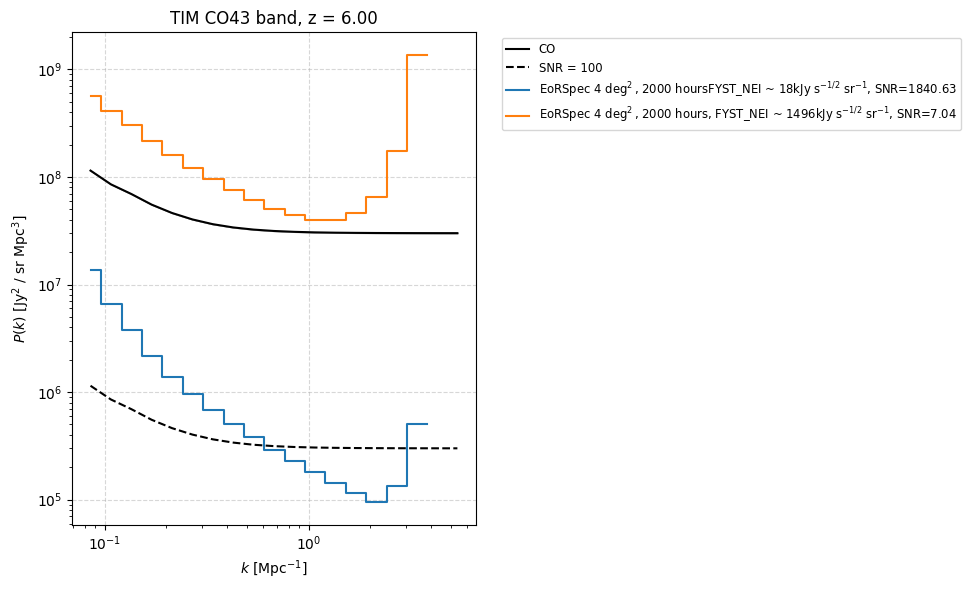

In [78]:
percentiles = [16, 50, 84]
psCOslow = [np.percentile(pscii, percentiles[0], axis=0)[1:-1] for pscii in psCOs]
psCOsup = [np.percentile(pscii, percentiles[2], axis=0)[1:-1] for pscii in psCOs]

fig, axs = plt.subplots(1, 1, figsize=(10, 6), sharex=True, sharey=True)
# axs = axs.flatten()
axs = [axs]
for i, ax in enumerate(axs):
    ax.fill_between(KSs[i][1:-1], psCOslow[i], psCOsup[i], color='grey', alpha=0.5)
    ax.plot(KSs[i][1:-1], psCOsmedian[i], color='black', label='CO')
    
    ax.plot(KSs[i][1:-1], psCOsmedian[i] / 100, color='black', label='SNR = 100', linestyle='--')
    
    for exp in COexps.values():
        KSs_exp, psCO_exp, Pstd_exp, binned_total_exp, Nmodes_exp, Pn_exp, binned_wbeams_exp, binned_whpfs_exp, label = exp
        SNR = psCO_exp[i] / Pstd_exp[i]
        ax.step(KSs_exp[i][1:-1], Pstd_exp[i], where='mid', label=label + f', SNR={np.nansum(SNR):.2f}')
        # ax.text(.1, 1, f', SNR={np.nansum(SNR):.2f}')
    
    ax.set_xscale('log')
    ax.set_yscale('log')
    ax.set_title(f'TIM {bands[i]} band, z = {CALCZs[i]:.2f}')
    ax.set_xlabel(r'$k$ [Mpc$^{-1}$]')
    ax.set_ylabel(r'$P(k)$ [Jy$^2$ / sr Mpc$^3$]')
    ax.grid(linestyle='--', alpha=0.5)
plt.legend(bbox_to_anchor=(1.05, 1), loc='upper left', fontsize='small')
plt.tight_layout()
plt.show()